In [1]:
# Elvessa Tatum

## Introduction
we aim to forecast future retail sales using historical sales data from product families sold at Favorita stores located in Ecuador.

## 1. Load and Inspect Data

In [2]:
import pandas as pd

# load the dataset
df = pd.read_csv('train.csv', parse_dates=['date'])

df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


## 2. Data Cleaning and Feature Engineering

In [4]:
# check for missing values
print(df.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [5]:
# There are none, excellent! Let's move on to making time based features

In [6]:
# extract time-based features
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek

## 3. Exploratory Data Analysis

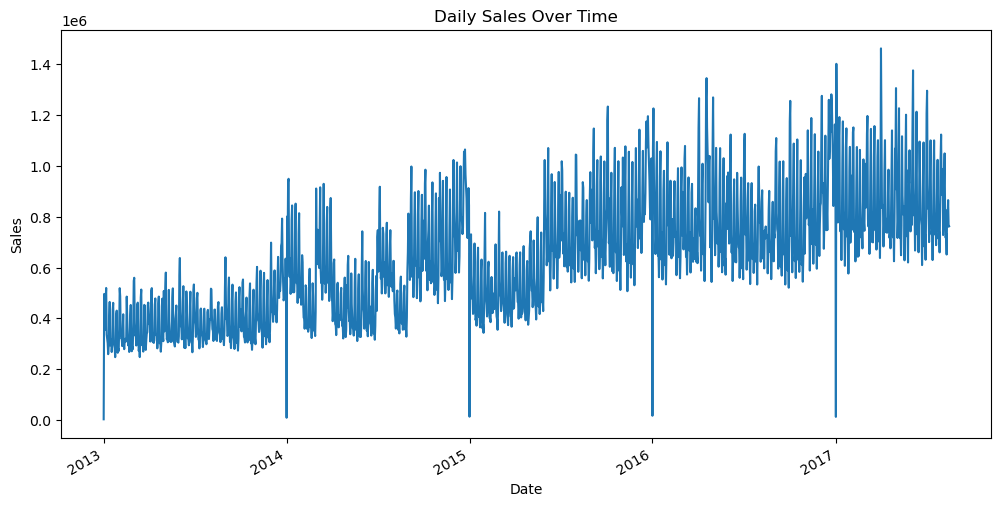

In [7]:
import matplotlib.pyplot as plt

# aggregate sales by date
daily_sales = df.groupby('date')['sales'].sum()

# plot daily sales
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

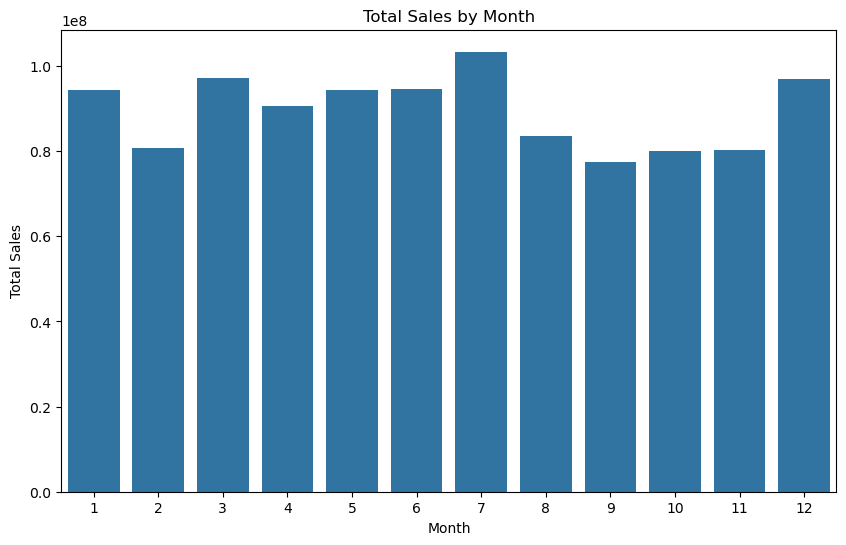

In [8]:
import seaborn as sns
# group sales by month
monthly_sales = df.groupby('month')['sales'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

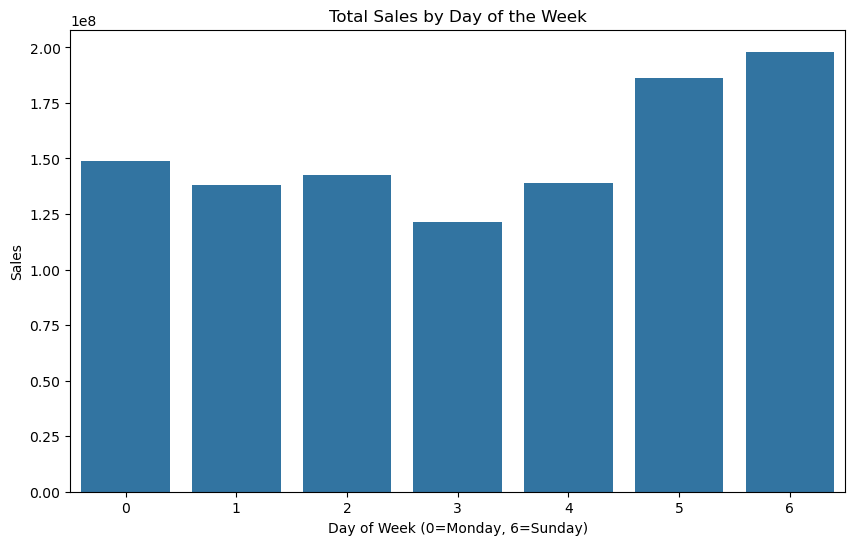

In [9]:
# day of week total sales
dow_sales = df.groupby('day_of_week')['sales'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=dow_sales.index, y=dow_sales.values)
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Sales')
plt.show()

## 4. Modeling

In [10]:
# define cutoff date for training and testing, and make training and testing sets
cutoff_date = '2017-01-01'
train = df[df['date'] < cutoff_date]
test = df[df['date'] >= cutoff_date]

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# aggregate sales by date
train_sales = train.groupby('date')['sales'].sum()

# set frequency to daily
train_sales = train_sales.asfreq('D')

# now fit SARIMA model
model = SARIMAX(train_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()

# forecast
forecast = results.get_forecast(steps=len(test['date'].unique()))
predicted_mean = forecast.predicted_mean

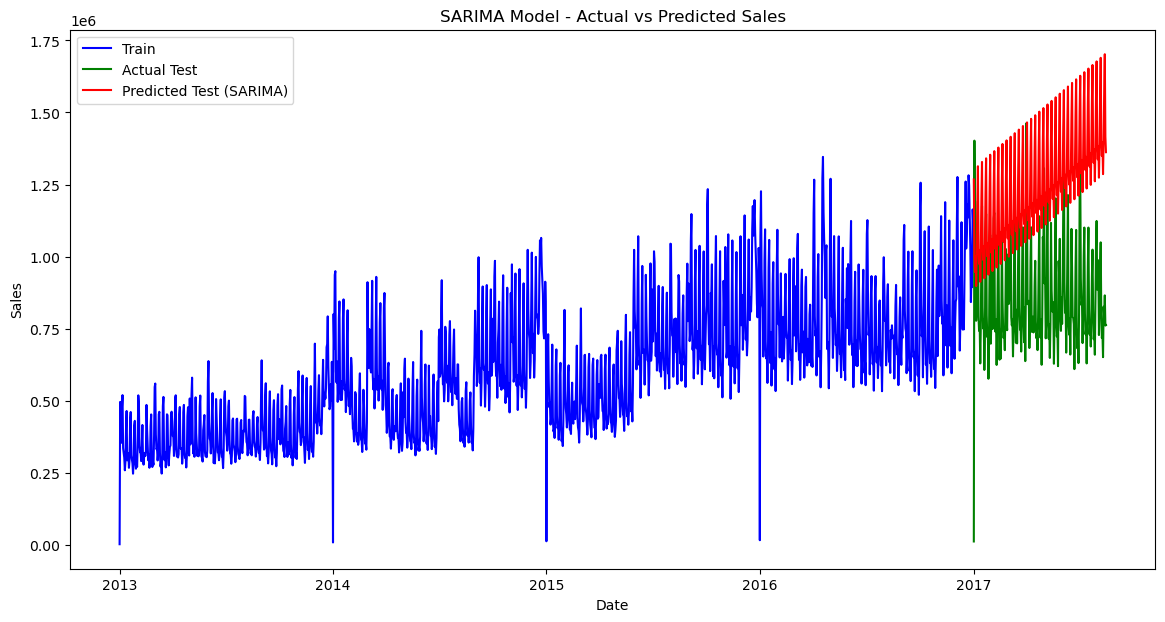

In [12]:
# aggregate actual sales for test set
actual = test.groupby('date')['sales'].sum()

# make sure predicted_mean is same length as actual
predicted = predicted_mean[:len(actual)]

# plot SARIMA Forecast
plt.figure(figsize=(14, 7))
plt.plot(train.groupby('date')['sales'].sum(), label='Train', color='blue')
plt.plot(actual.index, actual, label='Actual Test', color='green')
plt.plot(actual.index, predicted, label='Predicted Test (SARIMA)', color='red')
plt.title('SARIMA Model - Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [13]:
from prophet import Prophet

# prepare data for Prophet
prophet_df = train.groupby('date')['sales'].sum().reset_index()
prophet_df.columns = ['ds', 'y']

# initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# create future dataframe
future = prophet_model.make_future_dataframe(periods=len(test['date'].unique()))
forecast = prophet_model.predict(future)

21:06:00 - cmdstanpy - INFO - Chain [1] start processing
21:06:00 - cmdstanpy - INFO - Chain [1] done processing


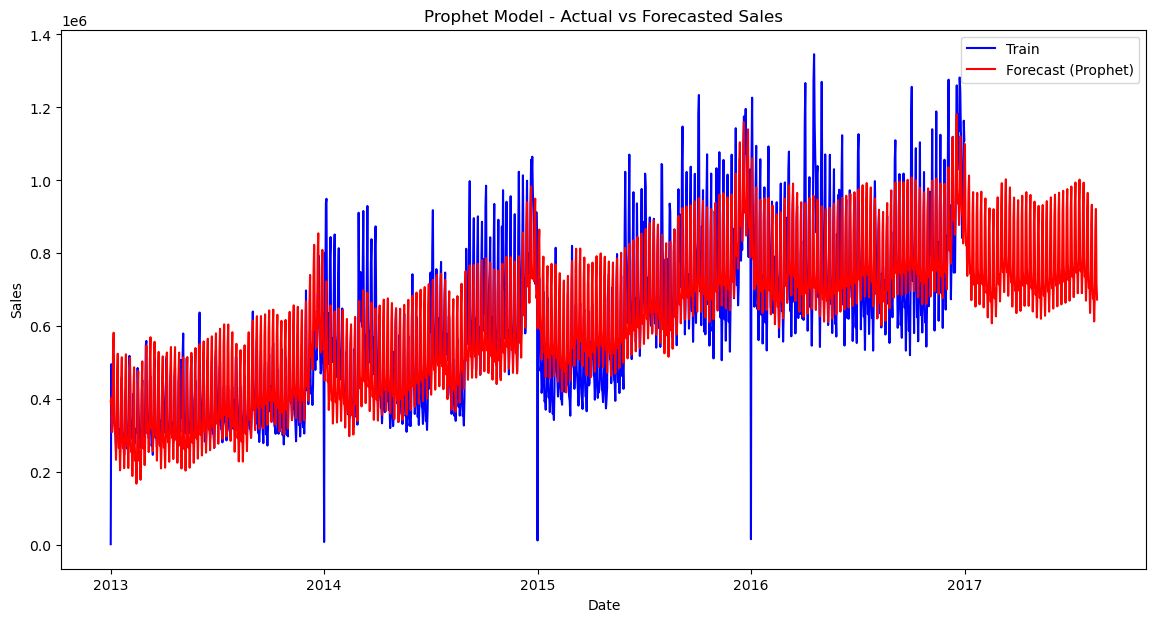

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Train', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Prophet)', color='red')
plt.title('Prophet Model - Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

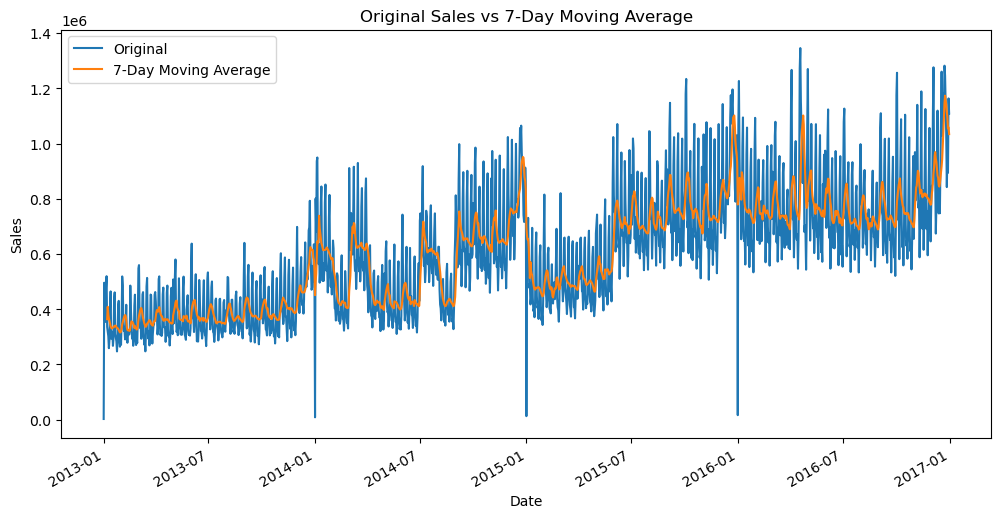

In [15]:
# calculate moving average
moving_avg = train.groupby('date')['sales'].sum().rolling(window=7).mean()

# plot moving average vs original sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
train.groupby('date')['sales'].sum().plot(label='Original')
moving_avg.plot(label='7-Day Moving Average')
plt.title('Original Sales vs 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 5. Evaluation

In [16]:
# evaluating SARIMA model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# actual sales
actual = test.groupby('date')['sales'].sum()

# make sure predicted_mean from SARIMA matches the test set length
predicted = predicted_mean[:len(actual)]

# calculate metrics
rmse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
mape = (abs((actual - predicted) / actual).mean()) * 100

print(f'SARIMA RMSE: {rmse}')
print(f'SARIMA MAE: {mae}')
print(f'SARIMA MAPE: {mape}%')


SARIMA RMSE: 187864310676.90134
SARIMA MAE: 404867.8403458795
SARIMA MAPE: 94.98297005595363%


In [17]:
# evaluating Prophet model

# get only the forecasted part that matches test set dates
forecast_test = forecast.set_index('ds').loc[test['date'].unique()]
forecasted_sales = forecast_test['yhat']

# prophet evaluation
rmse_prophet = mean_squared_error(actual, forecasted_sales)
mae_prophet = mean_absolute_error(actual, forecasted_sales)
mape_prophet = (abs((actual - forecasted_sales) / actual).mean()) * 100

print(f'Prophet RMSE: {rmse_prophet}')
print(f'Prophet MAE: {mae_prophet}')
print(f'Prophet MAPE: {mape_prophet}%')

Prophet RMSE: 22334269406.310436
Prophet MAE: 96327.96515666434
Prophet MAPE: 49.223125930579535%


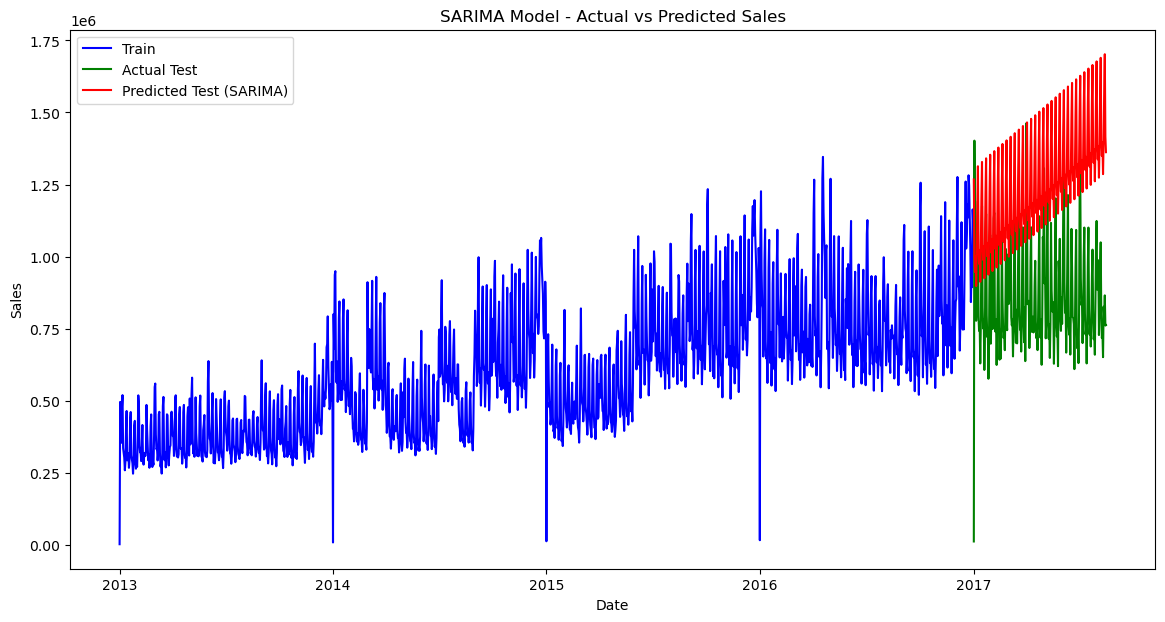

In [18]:
# plotting actual vs predicted for SARIMA
plt.figure(figsize=(14,7))
plt.plot(train.groupby('date')['sales'].sum(), label='Train', color='blue')
plt.plot(actual.index, actual, label='Actual Test', color='green')
plt.plot(actual.index, predicted, label='Predicted Test (SARIMA)', color='red')
plt.title('SARIMA Model - Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

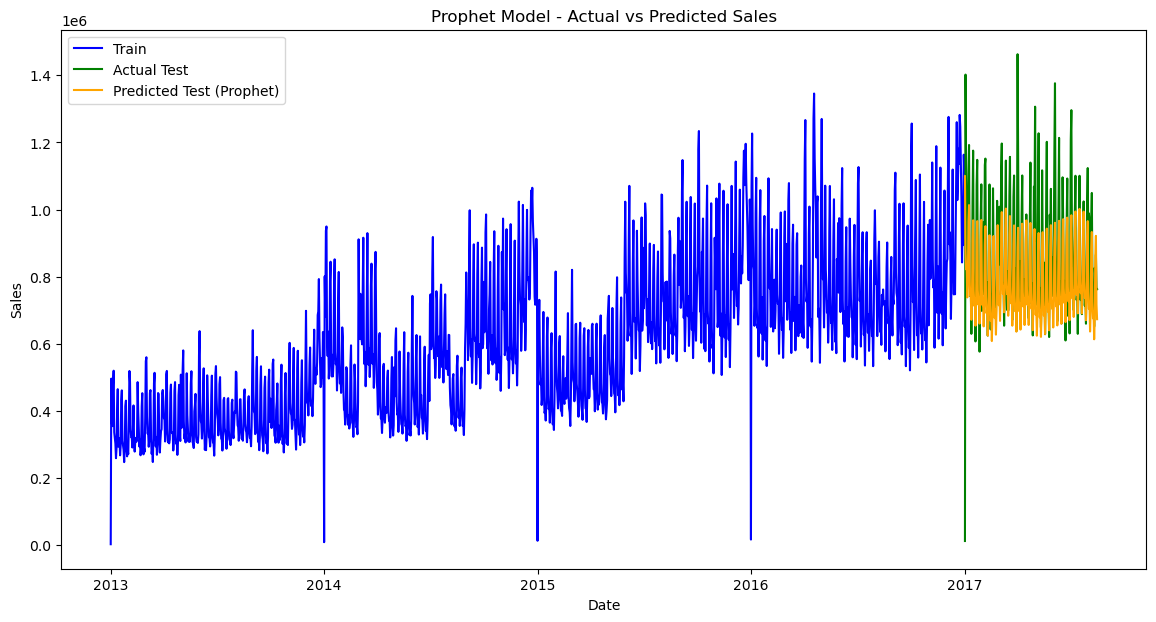

In [19]:
# actual vs predicted for Prophet
plt.figure(figsize=(14,7))
plt.plot(train.groupby('date')['sales'].sum(), label='Train', color='blue')
plt.plot(actual.index, actual, label='Actual Test', color='green')
plt.plot(forecast_test.index, forecasted_sales, label='Predicted Test (Prophet)', color='orange')
plt.title('Prophet Model - Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

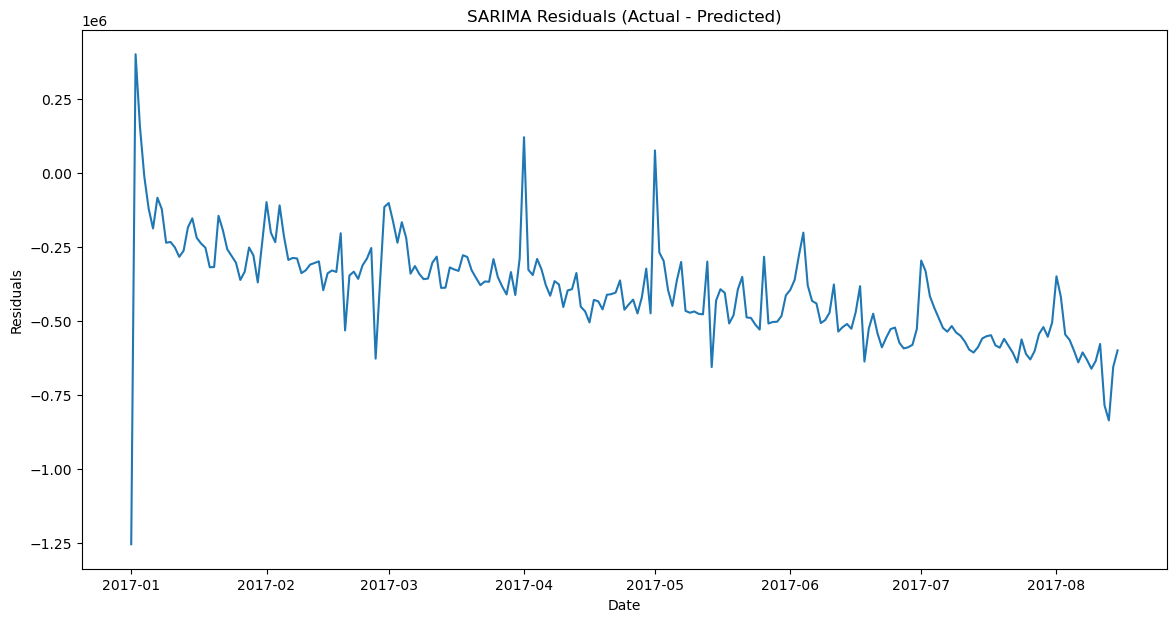

In [20]:
# SARIMA residuals
sarima_residuals = actual - predicted

plt.figure(figsize=(14,7))
plt.plot(sarima_residuals)
plt.title('SARIMA Residuals (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

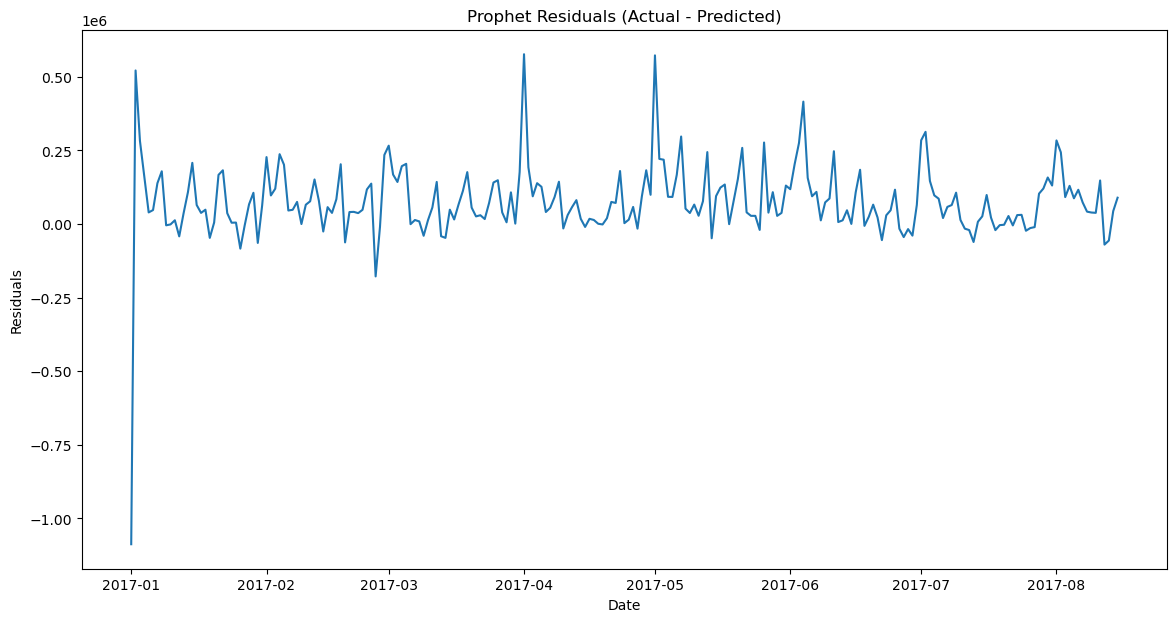

In [21]:
# Prophet residuals
prophet_residuals = actual - forecasted_sales

plt.figure(figsize=(14,7))
plt.plot(prophet_residuals)
plt.title('Prophet Residuals (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

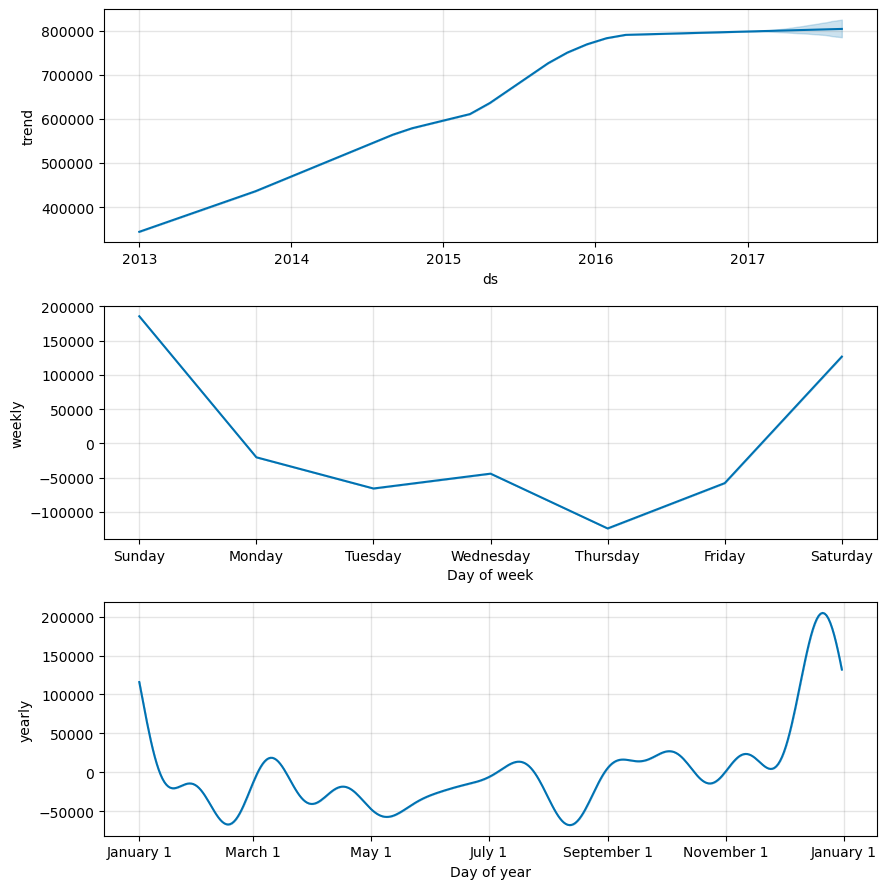

In [22]:
# Prophet seasonality and trend plots
prophet_model.plot_components(forecast)
plt.show()